# Attention Layers

We Implement a self-attention layer from scratch using PyTorch. 
Additionally, we construct a classification model consisting of one self-attention layer followed by a fully connected layer.

In [ ]:


import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        #query matrix, key matrix, value matrix Q, K, V
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim) 
        self.value = nn.Linear(input_dim, input_dim)
        #https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        K_T = K.transpose(-1, -2) #note to self, torch.t and torch.transpose are not the same, also need to specify dims
        Q_K_T= torch.bmm(Q, K_T) #for pytorch bmm performs "batch matrix-matrix product of matrices"
        #d is normalization scaling
        d= self.input_dim
        M_cap= Q_K_T/math.sqrt(d)
        #ATT: Rl1×dk × Rl2×dk × Rl2×dv → Rl1×dv from the slides
        M = self.softmax(M_cap)
        return M_cap, V
class Fully_Connected_Layer(nn.Module):
    def __init__(self, input_dim):
        super(Fully_Connected_Layer, self).__init__()
        self.fc_layer = nn.Linear(input_dim, input_dim)
    def forward(self, x):
        return self.fc_layer(x)
    
class Joint_Layers(nn.Module):
    def __init__(self, input_dim):
        super(Joint_Layers, self).__init__()
        self.self_attention = SelfAttention(input_dim)
        self.fc_layer = Fully_Connected_Layer(input_dim)
    def forward(self, X, Y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        attention_weights, values = self.self_attention(X_tensor)
        predictions = self.fc_layer(values)
        return predictions, attention_weights, Y_tensor
        

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def split_and_convert_to_tensors(X, Y, train_size=0.8, test_size=0.2):
    np.random.seed(1)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X, Y = X[indices], Y[indices]
    n_train = int(len(X) * train_size)
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_test, Y_test = X[n_train:], Y[n_train:]
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)#only to X i need a "sequence"
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)#only to X i need a "sequence"
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
    return X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor


def visualization(attention_weights):
    attention_weights = attention_weights.squeeze().detach().numpy()
    attention_weights = attention_weights.reshape(1, -1)

    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_weights)
    plt.xlabel("Features")
    plt.title("Weights")
    plt.tight_layout()
    plt.show()


def train_and_test_model(X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, input_dim, epochs, batch_size=16, miu=0.01):
    model = Joint_Layers(input_dim)
    loss_criteria = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), miu)
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        model.train()
        epoch_loss =0.0
        for X_batch, Y_batch in train_loader:
            predictions, _, _ = model(X_batch, Y_batch)
            predictions = predictions.squeeze(1)
            Y_batch = Y_batch.long()
            loss = loss_criteria(predictions, Y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print("Epoch", epoch+1, "/", epochs, ", Loss: ", epoch_loss)
    model.eval()
    with torch.no_grad(): #to run without affecting, testing
        predictions, attention_weights, _ = model(X_test_tensor, Y_test_tensor)
        predictions = predictions.squeeze(1)
        Y_test_tensor = Y_test_tensor.long()
        _, predicted_classes = torch.max(predictions, 1)
        correct = (predicted_classes == Y_test_tensor).sum().item()
        accuracy = correct / Y_test_tensor.size(0)
        print("Test Accuracy:  ",accuracy)
        #print(attention_weights.squeeze().detach().numpy())
        visualization(attention_weights)

    return model, accuracy



C:\Users\josep\AppData\Local\Temp\ipykernel_20712\2281854918.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
C:\Users\josep\AppData\Local\Temp\ipykernel_20712\2281854918.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y, dtype=torch.float32)


Epoch 1 / 20 , Loss:  12.00667154788971
Epoch 2 / 20 , Loss:  9.135329127311707
Epoch 3 / 20 , Loss:  7.2891581654548645
Epoch 4 / 20 , Loss:  5.897262334823608
Epoch 5 / 20 , Loss:  4.774075031280518
Epoch 6 / 20 , Loss:  4.013842523097992
Epoch 7 / 20 , Loss:  3.5463463068008423
Epoch 8 / 20 , Loss:  3.0230879485607147
Epoch 9 / 20 , Loss:  2.735535904765129
Epoch 10 / 20 , Loss:  2.554648593068123
Epoch 11 / 20 , Loss:  2.380050629377365
Epoch 12 / 20 , Loss:  2.2714468389749527
Epoch 13 / 20 , Loss:  2.0419142693281174
Epoch 14 / 20 , Loss:  1.9674778431653976
Epoch 15 / 20 , Loss:  1.8301585242152214
Epoch 16 / 20 , Loss:  1.7056546434760094
Epoch 17 / 20 , Loss:  1.638943076133728
Epoch 18 / 20 , Loss:  1.5847541689872742
Epoch 19 / 20 , Loss:  1.456699088215828
Epoch 20 / 20 , Loss:  1.3705769255757332
Test Accuracy:   0.9333333333333333


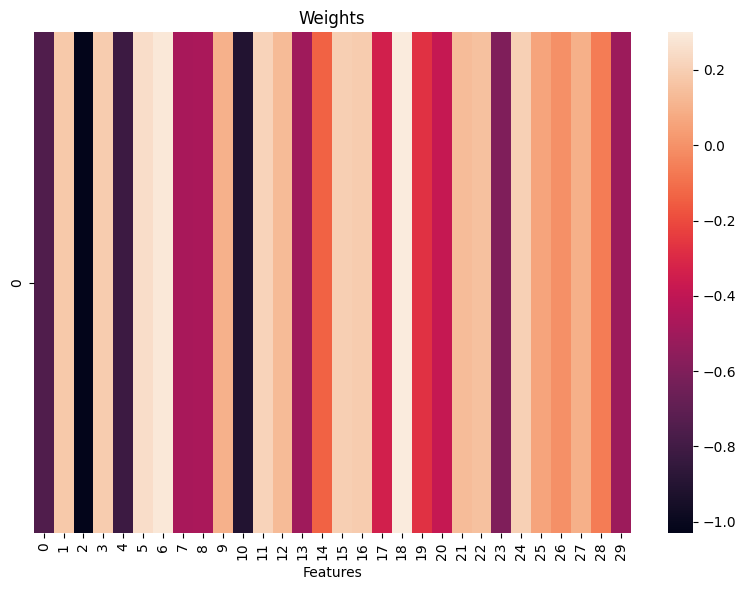

Final Testing Accuracy:  0.9333333333333333


In [3]:
iris_data = pd.read_csv("iris.data", delimiter=",", header=None)


labels = np.unique(iris_data.iloc[:,-1])
labels_coded = dict(zip(labels, range(1, len(labels) + 1)))
iris_data.iloc[:,-1] = iris_data.iloc[:,-1].map(labels_coded)
Y=iris_data.iloc[:, -1]
X = iris_data.drop(iris_data.columns[-1], axis=1)


def scale(x,mean, std):
    z= (x-mean)/std
    return z
for xn in X.columns:
    mean, std= X[xn].mean(), X[xn].std()
    X[xn] = scale(X[xn], mean, std)


X = X.to_numpy()
Y = Y.to_numpy()
Y = Y.astype(np.int64)

#input_dim = X.shape[1] 
#model = Joint_Layers(input_dim)
#predictions, attention_weights, Y_tensor = model(X, Y)

X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor = split_and_convert_to_tensors(X, Y)
input_dim = X_train_tensor.shape[2]
trained_model, test_accuracy = train_and_test_model(X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, input_dim, 20)

print("Final Testing Accuracy: ",test_accuracy)





In [4]:
%reset -f

# Transformer-Based Text Generator from scratch using PyTorch
It includes:
• An embedding layer for input tokens
• Positional encoding
• Multi-head self-attention (with a causal mask to prevent attending to future tokens)
• Feed-forward layers
• Residual connections and layer normalization

In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

#processing the text
#load, make lower case, find out how much to pad, pad, find unique words and convert my array into a tensor so i can use pytorch
HP_df = pd.read_csv("Harry_Potter_all_books_preprocessed.txt", sep=r'[.!?]', header=None, engine='python')
HP_df = HP_df.T
HP_df = HP_df.iloc[:50000]

HP_array = np.array(HP_df)
HP_array = HP_array.astype(str)
HP_array = np.char.lower(HP_array) #make lower case
sentences = HP_array.flatten()

max_length= 20 #attempt at optimizing time, max 20 words per sentence

split_sentences = [word.split()[:max_length] for word in sentences]
max_length = max(len(sentence) for sentence in split_sentences)
if max_length % 2 != 0:
    max_length += 1 #i make it an even number, it gives me trouble down the road



HP_array_padded = np.array([sentence + [''] * (max_length - len(sentence)) for sentence in split_sentences]) #multiply by a "padding distance"
unique_words_array = np.unique(HP_array_padded)

#will get dictionary for converting, but based on future parts also need a reversed one to "de-translate"

dictionary = {word: id_number for id_number, word in enumerate(unique_words_array)}
dictionary[''] = 0

coded_array = np.vectorize(lambda word: dictionary[word])(HP_array_padded)
coded_tensor = torch.tensor(coded_array, dtype=torch.long)

vocab_size = len(dictionary)
reverse_dictionary = {id_num: word_ for word_, id_num in dictionary.items()}

In [6]:
#now the Classes to build the model
#when we embed we describe each word in m amount of dimensiones, that will take as embedding_dim
class EmbeddingLayer(nn.Module):
    def __init__(self, word_range, embedding_dim):
        #in pytorch nn we need a super to initialze
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(word_range, embedding_dim, padding_idx=0)

    def forward(self, x):
        return self.embedding(x)

#for positional encoding we will take the max lenght of the sequence allowed
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_length):
        super(PositionalEncoding, self).__init__()
        #first we use this parameters for an empty matriz with zeroes
        self.encoding = torch.zeros(max_length, embedding_dim)
        #this uses the sin and cosine formulas from the article "Attention is all you need", page 6
        position = torch.arange(0, max_length).unsqueeze(1)
        denominator = torch.exp(torch.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
        self.encoding[:, 0::2] = torch.sin(position * denominator)
        self.encoding[:, 1::2] = torch.cos(position * denominator)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class MHA_FF_layers(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim):
        super(MHA_FF_layers, self).__init__()
        # there is a PyTorch MHA so will use that one
        # from documentation attn_mask (Optional[Tensor]) – If specified, a 2D or 3D mask preventing attention to certain positions
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)

        # we normalize with a PyTorch function
        self.norm1 = nn.LayerNorm(embedding_dim)
        # next we just apply a ff, a sequential like we have done in other exercises
        self.ff = nn.Sequential(nn.Linear(embedding_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, embedding_dim))
        # we normalize
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x, attn_mask=None):
        # we pass the values through our whole block
        attn_output, _ = self.attention(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

# now we try to run the model
class TransformerModel(nn.Module):
    def __init__(self, num_words, embedding_dim, max_length, num_heads, hidden_dim, num_layers):
        super(TransformerModel, self).__init__()
        # we embed and positionally encode as the first two layers
        self.embedding_layer = EmbeddingLayer(num_words, embedding_dim)
        self.positional_encoding_layer = PositionalEncoding(embedding_dim, max_length)
        self.mha_ff_layer_sequence = nn.ModuleList([MHA_FF_layers(embedding_dim, num_heads, hidden_dim) for _ in range(num_layers)])
        self.output_layer = nn.Linear(embedding_dim, num_words)

    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.positional_encoding_layer(x)
        # we create a triangular matrix of ones for the mask
        ones_torch = torch.ones(x.size(1), x.size(1))
        mask_to_use = torch.tril(ones_torch)
        for layer in self.mha_ff_layer_sequence:
            x = layer(x, attn_mask=mask_to_use)
        x = self.output_layer(x)
        return x



In [7]:
#Model parameters and training
embedding_dimensions = 100
num_heads = 20
hidden_dim = 400
num_layers = 6
number_of_words = len(dictionary)
max_length = max_length

model = TransformerModel(number_of_words, embedding_dimensions, max_length, num_heads, hidden_dim, num_layers)
loss_criteria = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #increasing learning rate has very bad effects in this case

In [8]:

def train_model(model, coded_tensor, epochs=7, batch_size=30): #i try different batch sizes since it runs very slowly
    dataset = torch.utils.data.TensorDataset(coded_tensor[:, :-1], coded_tensor[:, 1:])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_seq, target_seq in dataloader:
            optimizer.zero_grad()
            output = model(input_seq)
            output = output.view(-1, vocab_size)
            target_seq = target_seq.view(-1)
            loss = loss_criteria(output, target_seq)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

def predict_next_word(model, input_seq):
    model.eval()
    with torch.no_grad():
        output = model(input_seq.unsqueeze(0))
        predicted_idx = torch.argmax(output[0, -1]).item()
        return reverse_dictionary[predicted_idx]

train_model(model, coded_tensor)

Epoch 1/7, Loss: 5.4641
Epoch 2/7, Loss: 2.1569
Epoch 3/7, Loss: 0.4230
Epoch 4/7, Loss: 0.2100
Epoch 5/7, Loss: 0.1464
Epoch 6/7, Loss: 0.1230
Epoch 7/7, Loss: 0.1200


## 2.3

In [10]:
#to add a custom input i need to split it first and turn it into a usable array
def prepare_input(sentence, dictionary, max_length):
    words_to_use = sentence.lower().split() #my dictionary is only lower case so we got to adjust so
    word_index_from_dictionary = [dictionary.get(word, 0) for word in words_to_use]
    if len(word_index_from_dictionary) < max_length:
        word_index_from_dictionary += [0] * (max_length - len(word_index_from_dictionary)) #adjust to padding
    else:
        word_index_from_dictionary = word_index_from_dictionary[:max_length]
    return torch.tensor(word_index_from_dictionary, dtype=torch.long)

def generate_text(model, input_sentence, dictionary, reverse_dictionary, num_words):
    model.eval()
    generated_words = []
    with torch.no_grad(): #so that i dont affect the model
        for _ in range(num_words):
            output = model(input_sentence.unsqueeze(0))
            predicted_ids = torch.argmax(output[0, -1]).item()  # iteratively predict the next word based on the previous
            generated_words.append(reverse_dictionary.get(predicted_ids, " "))
            #update the input sentence with the predicted word
            input_sentence = torch.cat((input_sentence[1:], torch.tensor([predicted_ids], dtype=torch.long)))
    return generated_words

#here in sentence you would add your custom prompt
sentence = "the day of the"
input_prompt = prepare_input(sentence, dictionary, max_length)
next_words = generate_text(model, input_prompt, dictionary, reverse_dictionary, num_words=10)

print("Prompt: ", sentence)
print("Predicted Words:", ' '.join(next_words))

Prompt:  the day of the
Predicted Words: the same balls of the other that the goblet of
